In [1]:
from train import train_epochs
from gan_toy import *
from utils.utils import *
from utils.exp1 import *
import utils.pytorch_utils as ptu
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from scipy.stats import norm
from tqdm import trange, tqdm_notebook

In [2]:
def exp1(train_data):
    loader_args = dict(batch_size=64, shuffle=True)
    train_loader = data.DataLoader(train_data, **loader_args)

    g = Generator(1, 3, 128, 1).to(ptu.device)
    c = Discriminator(1, 3, 128, 1).to(ptu.device)

    def g_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return (1 - critic(fake_data)).log().mean()

    def c_loss(generator, critic, x):
        fake_data = generator.sample(x.shape[0])
        return - (1 - critic(fake_data)).log().mean() - critic(x).log().mean()
    g_opt = optim.Adam(g.parameters(), lr=1e-4, betas=(0, 0.9))
    c_opt = optim.Adam(c.parameters(), lr=1e-4, betas=(0, 0.9))
    train_args = {
        "epochs": 15, 
        "n_critic": 10, 
        "final_snapshot":True
    }
    result = train_epochs(g, c, g_loss, c_loss, train_loader, train_args, g_opt=g_opt, c_opt=c_opt)
    train_losses, samples_1, xs_1, critic_1, samples_final, xs_final, critic_final = result
    return train_losses['c_losses'], samples_1, xs_1, critic_1, samples_final, xs_final, critic_final

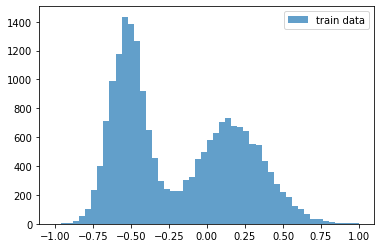

In [3]:
visualize_experiment_dataset()

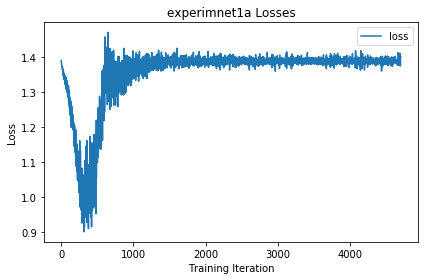

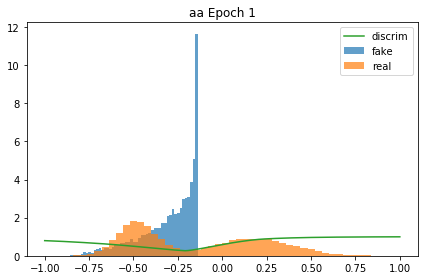

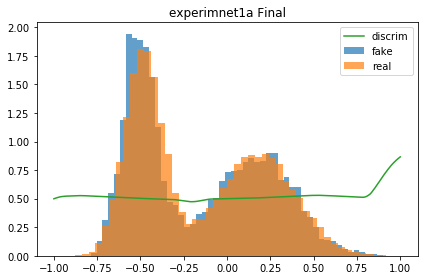

In [4]:
experiment_save_results('a', exp1, "experimnet1")